   X..100130426  X..100133144  X..100134869  X..26823  X..340602  X..388795  \
0      1.073073      4.729118      4.775573  0.979959   0.394964   2.854417   
1    -16.609640     -0.242448    -16.609640  0.757544 -16.609640   2.927481   
2    -16.609640      5.473930      3.098067  3.934565 -16.609640   1.612640   
3    -16.609640    -16.609640    -16.609640  2.374263 -16.609640   2.959234   
4    -16.609640      5.969699      4.130841 -0.084043  -0.084043   3.085868   

   X..391343  X..391714  X..441362  X..652919  ...  hsa.mir.942  hsa.mir.943  \
0   2.716905   0.394964  -16.60964   6.692080  ...     6.145828    -16.60964   
1 -16.609640   1.342504  -16.60964   4.711749  ...     5.359048    -16.60964   
2 -16.609640 -16.609640  -16.60964   5.969719  ...     5.864824    -16.60964   
3 -16.609640 -16.609640  -16.60964   1.374294  ...     5.138112    -16.60964   
4 -16.609640   1.500909  -16.60964   7.874605  ...     5.560551    -16.60964   

   hsa.mir.944  hsa.mir.95  hsa.mir.96  hsa.

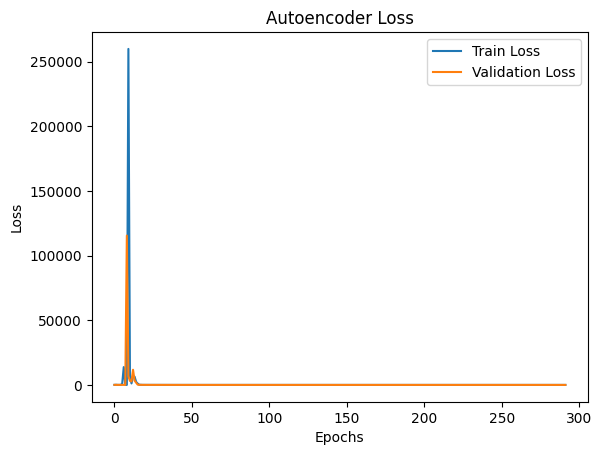

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
from torch.cuda.amp import GradScaler, autocast
import pandas as pd

dataset_name = "aml"
df = pd.read_csv(f"../dataset/processed/{dataset_name}/final_data.csv")
df.dropna(inplace=True)
print(df.head())
print(df.shape)
df.drop(["Survival", "Death"], inplace=True, axis=1)
df.shape
# Assuming `df` is a pandas DataFrame
input_features = df.shape[1]
data = df.values.astype(np.float32)

# Split data into train and validation sets
train_data, val_data = train_test_split(data, test_size=0.2, random_state=42)

# Convert to PyTorch tensors
train_data = torch.tensor(train_data)
val_data = torch.tensor(val_data)

# Create data loaders
batch_size = 32
train_loader = torch.utils.data.DataLoader(
    train_data, batch_size=batch_size, shuffle=True
)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size, shuffle=False)


# Define the Autoencoder model
class Autoencoder(nn.Module):
    def __init__(self, input_dim):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, input_dim // 2),
            nn.LeakyReLU(),
            nn.Linear(input_dim // 2, input_dim // 4),
            nn.LeakyReLU(),
            nn.Linear(input_dim // 4, input_dim // 8),
            nn.LeakyReLU(),
            nn.Linear(input_dim // 8, input_dim // 16),
            nn.LeakyReLU(),
        )
        self.decoder = nn.Sequential(
            nn.Linear(input_dim // 16, input_dim // 8),
            nn.LeakyReLU(),
            nn.Linear(input_dim // 8, input_dim // 4),
            nn.LeakyReLU(),
            nn.Linear(input_dim // 4, input_dim // 2),
            nn.LeakyReLU(),
            nn.Linear(input_dim // 2, input_dim),
            nn.LeakyReLU(),
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded


# Initialize the model, optimizer, and loss function
model = Autoencoder(input_dim=input_features)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
model.to(device)

# Early stopping parameters
early_stopping_patience = 25
best_loss = float("inf")
patience_counter = 0

# Training the model
num_epochs = 1000
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    # Training phase
    model.train()
    train_loss = 0
    for batch in train_loader:
        batch = batch.to(device)
        optimizer.zero_grad()
        output = model(batch)
        loss = criterion(output, batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    train_loss /= len(train_loader)
    train_losses.append(train_loss)

    # Validation phase
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for batch in val_loader:
            batch = batch.to(device)
            output = model(batch)
            loss = criterion(output, batch)
            val_loss += loss.item()

    val_loss /= len(val_loader)
    val_losses.append(val_loss)

    print(
        f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}"
    )

    # Early stopping
    if val_loss < best_loss:
        best_loss = val_loss
        patience_counter = 0
        torch.save(
            model.state_dict(), f"../models/{dataset_name}_autoencoder.pth"
        )  # Save the model
    else:
        patience_counter += 1
        if patience_counter >= early_stopping_patience:
            print("Early stopping triggered.")
            break

# Plot the training and validation loss
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Autoencoder Loss")
plt.savefig(f"../models/{dataset_name}_autoencoder_loss.png")
plt.show()